# Trajectory Optimization

<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S75_drone_planning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q -U gtbook

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import numpy as np
import plotly.subplots as pls
import plotly.graph_objects as go
import plotly.express as px

import gtsam
from gtsam import Point2
import gtbook.drone as gtbook_drone
from gtbook.drone import Drone

try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

```{index} planning; trajectory optimization
```

> We can optimize over future trajectories, as well.

<img src="Figures7/S75-Autonomous_camera_drone-05.jpg"  alt="Splash image with steampunk drone in aggressive maneuver" width="40%" align=center style="vertical-align:middle;margin:10px 0px">


In the previous section we saw how to use factor graphs for visual SLAM and structure from motion. These perception algorithms are typically run after the robot has gathered some visual information, and provide information about what happened in the past. But how can we plan for the future? 

We already saw that RRTs are a useful tool for planning in a continuous, potentially high dimensional state space. However, RRTs are not concerned with optimality. They aim for feasible paths, where sometimes feasibility means "collision-free" and sometimes it includes honoring the system dynamics. But if we want to achieve optimal trajectories in terms of time to goal, best use of energy, or minimum distance, we need to turn to other methods.

```{index} trajectory optimization
```
In this section we will discuss optimization methods for control. In particular, we will use **trajectory optimization**, to minimize the cost associated with the trajectory to be executed in the future. These costs can be associated with staying away from obstacles, or other desirable properties like minimizing power consumption to preserve battery life. RRTs and trajectory optimization can be combined, where an RRT provides a good "broad strokes" trajectory, and a trajectory optimization smooths out and fine-tunes the final trajectory.

We explain trajectory optimization using a very simple problem: how to get from point A to point B. This seems like an easy problem, as we all know the answer should be a straight line, right? But, it is not as easy for drones, as we have to account for the drone's attitude, and we might have to accelerate and decelerate at the start and end points. Come to think of it, maybe we are already flying at a certain velocity at point A, and want to have a certain velocity at point B! Clearly, this is not as easy as it appears.

Below we go about finding an optimal trajectory in steps:
- We explain how finding an optimal *path* is all we need to do as a first step.
- We discuss how to represent environments that contain obstacles using maps.
- We introduce factor graphs to find an optimal path in those maps.
- We show how a path solution can be converted into a *trajectory* using interpolation in time.

Once we have developed methods for computing an optimal trajectory,
we then show the broad outlines of building a simple cascaded controller that is able to execute these trajectories. 
Using the drone kinematics and dynamics models from Section 7.2, we  show how to implement such controllers and evaluate them in simulation.

## Optimizing for Position

> Position is all we need for the first step.

```{index} under-actuated
```
In many applications, the drone configuration can effectively be decomposed into its position and orientation
components: the position variables define a path through Euclidean space, and the orientation
variables can be used to achieve the desired accelerations and velocities of the drone to follow 
that path (recall
that a drone exerts thrust parallel to its body $z$-axis, so the orientation of the drone
determines the direction of motion). 
We know from Section 7.2 that the drone's attitude will *affect* position: 
pitch or roll will affect the velocity, which that will integrate into position. 
When given a continuous set of positions (i.e., a curve in $\mathbb{R}^3$) to get us from A to B, we can obtain the pitch, roll, and thrust trajectories to realize it.
This very mechanism for controlling motion is also a source of complexity: a drone is **under-actuated**.
We cannot directly control all six DOF, since we have only four rotors. 

```{index} path, free path, trajectory
```
Recall from Section 5.5 that a **free path** is defined as a continuous mapping of
the unit interval to the free configuration space: $\gamma : [0,1] \rightarrow {\cal Q}_\mathrm{free}$,
such that $q(0) = q_\mathrm{init}$ and $q(1) = q_\mathrm{goal}$.
This unit-length parameterization of the path hides the dynamics of the drone;
there is no notion of time in this representation.
When we choose a time parameterization of the path, the resulting $\gamma(t)$ defines
a **trajectory**, which fully defines the dynamics of the desired motion.
For example, we can differentiate the trajectory with respect to time to obtain the instantaneous velocity.

If we decouple position and orientation, the problem of finding a path for the position variables
is to compute a continuous $\gamma: [0,1] \rightarrow \mathbb{R}^3$, i.e., we ignore the orientation of the drone.
In this chapter, we will do so using an optimization-based approach.
There are many ways one can do this, some better than others, but here we strive for simplicity:
we discretize the time interval in which we expect to fly, and solve for a corresponding sequence of positions
$(X_1, \dots X_K)$ that satisfy our objectives. These objectives include

- a desired starting position,
- a desired goal position,
- an objective function to facilitate obstacle avoidance, and
- a smoothness objective that bounds velocity and/or acceleration.

If these objectives are in conflict, we can assign them weights such that we trade off some against others. *Constrained optimization* techniques allow to set hard constraints and/or bounds, but we do not use those here. Instead, we opt for a simple nonlinear least-squares scheme that finds the path $X^*$ that minimizes the following objective:
\begin{equation}
X^* = \arg \min \sum_{k=1}^K \phi_k(X_k)^2  + \sum_{k=1}^{K-1} \psi_k(X_k, X_{k+1})^2
\end{equation}
where $X_k$ is the position at time, and $\phi_k(X_k)$ and $\psi_k(X_k, X_{k+1})$ are unary and binary objectives, respectively, that we want to minimize. 
Desired start and goal position, as well as obstacle avoidance are examples of unary objectives, while smoothness is a binary objective, which can be expressed in terms of the distance between successive points along the path.

It will not come as any surprise that we can also use factor graph optimization to solve this optimization problem.
The objective above is exactly the expression of a nonlinear factor graph, except that the factors now derive from objectives we want to minimize, rather than measurement errors. In the next section we work out in detail how to do so.

Note that when we use this discrete optimization approach, the result is merely a set of points,
not a continuous path. Below, we will show how to convert the discretized path into a smooth trajectory.

## Occupancy and Cost Maps

> We can use maps to encode costs to minimize.

```{index} occupancy map
```
A popular approach to represent environments with obstacles is to use an **occupancy map**. An occupancy map is essentially a 2D array of cells, and we have already used this concept in Section 4.3. 
After we choose a certain resolution (for example, 10 cm by 10 cm), each cell in the map contains a probability for the presence of an obstacle. This concept can be extended to distinguish between various types of obstacles, 
for example if some obstacles pose more significant threat than others.

```{index} cost map
```
This extended version of an occupancy can be further extended to a **cost map**, 
where areas with less hazardous obstacles (like tall grass) are considered less costly compared to more dangerous ones (like flying into a tree). Cost maps do not encode *occupancy* but rather encode the cost of being in a particular location. For our purposes, we will start directly with cost maps instead of creating true occupancy maps.

To illustrate, let us consider creating a simple example cost map. 
We will begin by considering the 2D case, which corresponds to the case of a drone flying at constant altitude. 
In the `gtbook/drone` library, we have a function named `create_random_map`. 
This function requires as parameters the width $W$, height $H$, and the number of obstacles,
and it creates a map that contains a random arrangement of obstacles. Width and height are given in meters, and the resolution is hard-coded at 10 cm. An optional parameter is a random seed, which allows for the reproduction of the exact experiment setup. Obstacles are generated with costs chosen randomly between 0.5 and 1.0.

The code snippet in Figure [1](#fig:obstacles) demonstrates how to generate a random map with 50 obstacles. Most of the environment has a cost of zero, and the obstacles are rendered in different shades of red based on their cost. Occasionally two obstacles overlap in which case the costs are added.

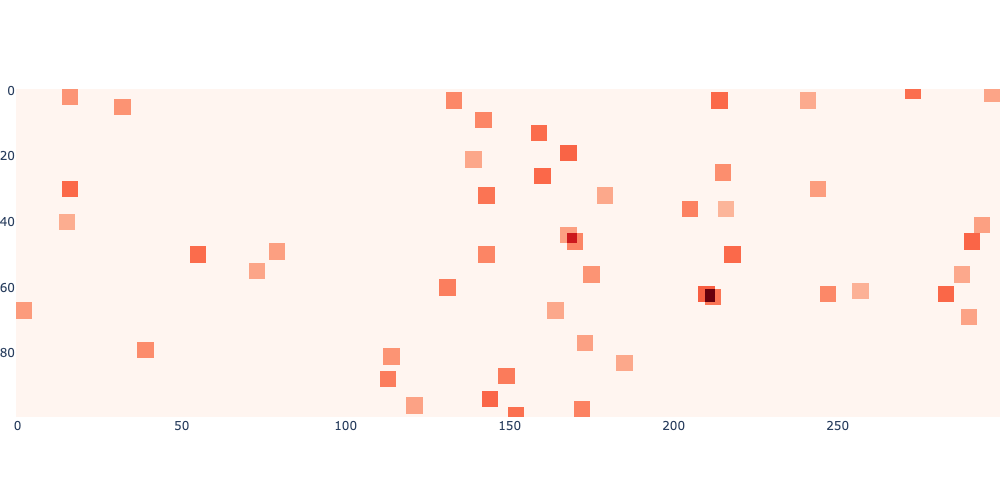

In [ ]:
#| caption: Cost map with randomly generated obstacles, at 10cm resolution.
#| label: fig:obstacles
# Create a random cost map
W, H = 30, 10  # 30m x 10m
cost_map = gtbook_drone.create_random_map(W, H, num_obstacles=50, seed=7)
fig = px.imshow(cost_map, color_continuous_scale='Reds')
fig.update_layout(coloraxis_showscale=False, margin=dict(l=0, r=0, t=0, b=0), width=1000)
fig.show()

A disadvantage to the map shown above is that large areas of the map contain cells with zero cost,
and therefore provide no information about locality of obstacles.
The transition from obstacle-free space to obstacle-occupied space is abrupt.
To improve the situation,  we can smooth the 
cost map with a differentiable kernel, like a Gaussian. 
We can use convolution to do this, just as we did for computer vision problems in Section 5.4.
A Gaussian kernel is a very popular choice for smoothing an image and removing noise, but here we wil use it to make the cost map "better behaved" for our purposes.

To do this in code, we have to be a bit careful.
We implemented maps in this section with PyTorch, following the image processing code in Section 5.4, and the cost map in Figure [1](#fig:obstacles) is a torch *tensor*. 
In particular, the cost map is represented as a grayscale image 100 pixels tall and 300 pixels wide.
Convolving an image with a kernel is relatively easy in PyTorch, although we need to juggle some tensor dimensions because by convention, `conv2d` operates on $\text{batch} \times \text{channel} \times \text{height} \times \text{width}$ tensors. The result is shown in Figure [2](#fig:blurred-map).

In [5]:
sigma = 0.5  # 0.5m standard deviation for the Gaussian kernel
K = 21 # 21x21 kernel is big enough to accommodate that standard deviation
kernel = gtbook_drone.gaussian_kernel(sigma*10, K) # multiply by 10 as map is 10cm resolution
batch = cost_map[None, None, ...]  # Add batch and channel dimensions
blurred = torch.conv2d(batch, kernel, padding='same')[0, 0, ...]

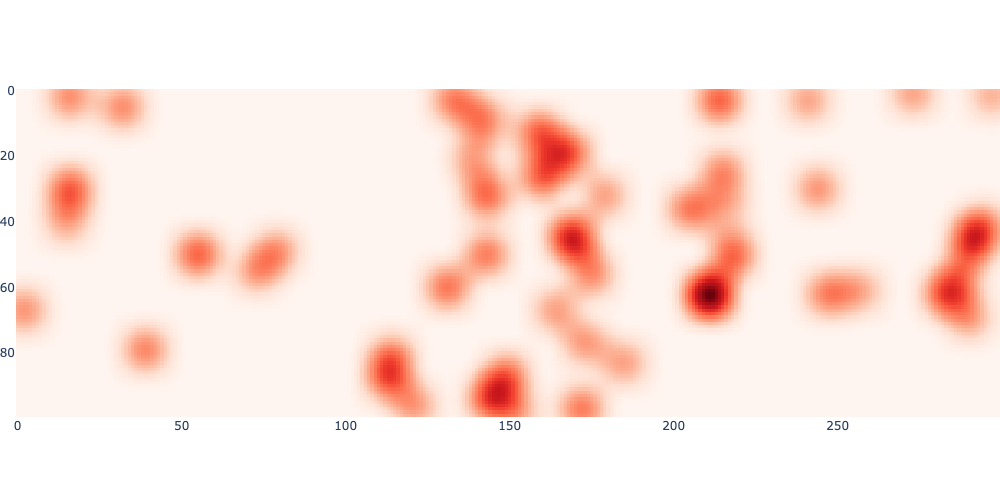

In [ ]:
#| caption: Cost map blurred with 0.5 meter Gaussian kernel.
#| label: fig:blurred-map
fig = px.imshow(blurred, color_continuous_scale='Reds')
fig.update_layout(coloraxis_showscale=False, margin=dict(l=0, r=0, t=0, b=0), width=1000)
fig.show()

## Making Costs (Truly) Differentiable

> Continuous smoothing, not convolution.

The discrete cost maps above are not differentiable; as we cross cell boundaries, the value of cost
makes a discontinuous jump.
Because of this, the factors $\phi_k(X_k)$ are not differentiable, which is a requirement of our optimization-based
approach.

To obtain truly differentiable factors, however, we can construct a custom Gaussian kernel at the *exact location*
at which we want to evaluate the cost. Remember we are trying to minimize a *path*, by selecting a set of positions $X_k$ at discrete time stamps $t_k$. It is important to realize that each $X_k$ can take on arbitrary real values
(not just integer coordinates of cells in the grid), and that the grid is an
approximate, discretized representation of the world and the cost of moving through the world. 

In nonlinear optimization, the story is always the same: evaluate the cost *and* its derivatives at a current guess for all $X_k$, and then use the spatial derivatives of the cost at each discretized pose $X_k$ to update the path
to a lower cost solution. We will use a factor graph to evaluate the cost and its derivative, so it is important that this cost is smooth and differentiable.

If we merely smooth a discretized cost map, as above, the result is still discretized, however smooth it looks to us. To get the *exact* value of the cost, and its derivatives, we can create a Gaussian kernel centered *exactly* at our current *continuous* position.
The function `gaussian_filter` defined in `gtbook` does just that: it evaluates a single Gaussian kernel operator given a standard deviation, a continuous map location, and the cost map. The code below shows that this gives the exact same result as a lookup in the blurred image when given an integer coordinate, but it *also* works for non-integer coordinates.

In [7]:
xy = Point2(7.5, 5.3) # point in map, in meters
uv = 10*xy # continuous position in image
local_result = gtbook_drone.gaussian_filter(sigma*10, uv, cost_map, K)
print(f"Local cost at {xy} is {local_result:.3f}")

# When uv are at integer values, blurred image gives the same result:
assert np.allclose(local_result, blurred[int(uv[1]), int(uv[0])])

Local cost at [7.5 5.3] is 0.135


To get the derivatives we blur the vertical and horizontal gradient images, respectively. 
Because convolution is a linear operation, 
we can compute the directional derivatives of the Gaussian kernel, *or* we can apply the convolution on a gradient image. We choose the latter, by first using the Sobel operator we encountered in Section 5.4 to create gradient images: 

In [8]:
# Compute gradients:
sobel_u, sobel_v = gtbook_drone.sobel_kernels()
grad_u = torch.conv2d(batch, sobel_u, padding='same')[0,0,...]
grad_v = torch.conv2d(batch, sobel_v, padding='same')[0,0,...]

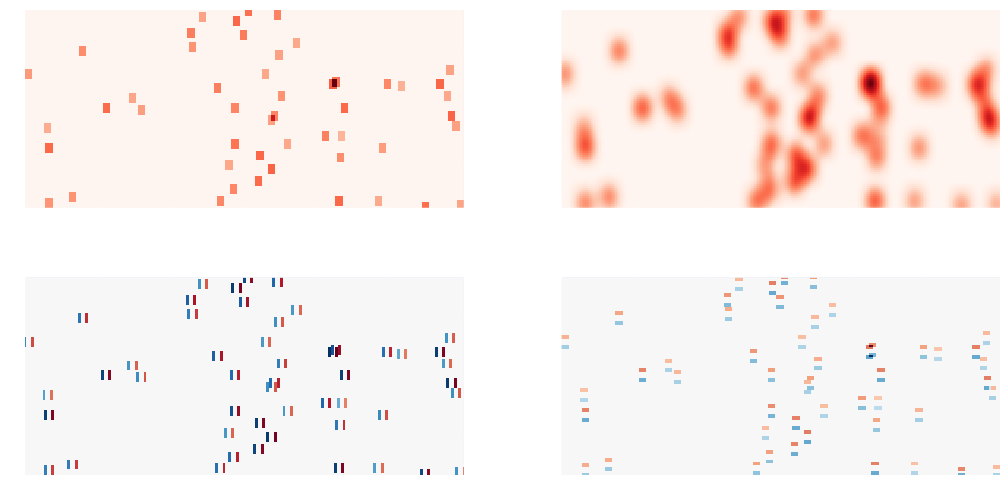

In [9]:
#| caption: Obstacle cost map, blurred cost map, and both vertical and horizontal sobel gradients.
#| label: fig:obstacles-2x2
fig = pls.make_subplots(rows=2, cols=2)
fig.add_trace(go.Heatmap(z=cost_map, colorscale='reds', showscale=False), row=1, col=1)
fig.add_trace(go.Heatmap(z=blurred, colorscale='reds', showscale=False), row=1, col=2)
fig.add_trace(go.Heatmap(z=grad_u, colorscale='rdbu', showscale=False), row=2, col=1)
fig.add_trace(go.Heatmap(z=grad_v, colorscale='rdbu', showscale=False), row=2, col=2)
for i in [1,2]:
    for j in [1,2]:
        fig.update_xaxes(title_text="", showticklabels=False, row=i, col=j)
        fig.update_yaxes(title_text="", showticklabels=False, row=i, col=j)
fig.update_layout(margin=dict(l=0, r=0, t=10, b=0), width=1000)
fig.show()

Figure [3](#fig:obstacles-2x2) shows both cost map and its blurred version, as well as the (un-blurred) gradient images `grad_u` and `grad_v`. We can then combine these into one rank-3 tensor and evaluate the cost *and* derivatives in one operation:

In [10]:
combined = torch.stack([cost_map, grad_u, grad_v], dim=0)
print(np.round(gtbook_drone.gaussian_filter(sigma*10, uv, combined, K),3))

[ 0.135  0.004 -0.004]


This gives us exactly what we need: because we blur  the cost map, the vertical component of the gradient, and the horizontal component of the gradient, we obtain three numbers: the cost at the location $u,v$, the derivative of the cost with respect to a change in $u$, and the derivative of the cost with respect to a change in $v$. Next, we show how to use this superpower in the context of factor graph optimization.

## Factor Graphs for Trajectory Optimization

Now that we can evaluate cost and its derivatives at any location, we can create factors. Since occupancy maps or cost maps are not built into GTSAM, we use its facility to create a custom factor from arbitrary python code. A `CustomFactor` just has a constructor that can take an arbitrary python callback function, along with a `Key` (and a noise model). At evaluation, the callback function gets a handle to the factor and a `Values` object, and it does three things:

- check which variable is involved, by asking the factor;
- with that key, extract the current estimate from the passed in `Values`;
- calculate the cost, and if asked, its derivatives.

The fact that we can do this for arbitrary python code is very convenient, and is used below to create cost factors that interrogate the cost map, using our localized Gaussian filter, and if asked, its derivatives:

In [11]:
def cost_func(factor: gtsam.CustomFactor, v: gtsam.Values, H: list[np.ndarray]):
    """Cost function for the custom factor."""
    # Extract the Point2 variable using the key in the factor
    point = v.atPoint2(factor.keys()[0])

    uv = 10 * point # Convert to map coordinates

    if H is None:
        cost = gtbook_drone.gaussian_filter(sigma * 10, uv, cost_map, K)
    else:
        # If derivatives are needed, calculate them here:
        cost, cost_x, cost_y = gtbook_drone.gaussian_filter(sigma * 10, uv, combined, K)
        H[0] = np.array([[cost_x, cost_y]])

    return np.array([cost]).astype(float)

Let us discretize the path using $M=100$ discrete time steps, using the keys $k\in 1...M$. We can define a start and goal point, and initialize the path as straight line. In other words, we initialize according to this formula:
\begin{equation}
X_k = (1-\alpha)\ X_{\text{start}} + \alpha\ X_{\text{goal}} \text{~~~with~} \alpha = \frac{k-1}{M-1},
\end{equation}
Who knows, we might be lucky and hit no obstacles along the way:

In [12]:
M = 100 # Number of points
start, goal = Point2(2, 5), Point2(28, 5)
initial = gtsam.Values()
for k in range(1,M+1):
    alpha = (k-1)/(M-1)
    initial.insert(k, (1-alpha)*start + alpha*goal)

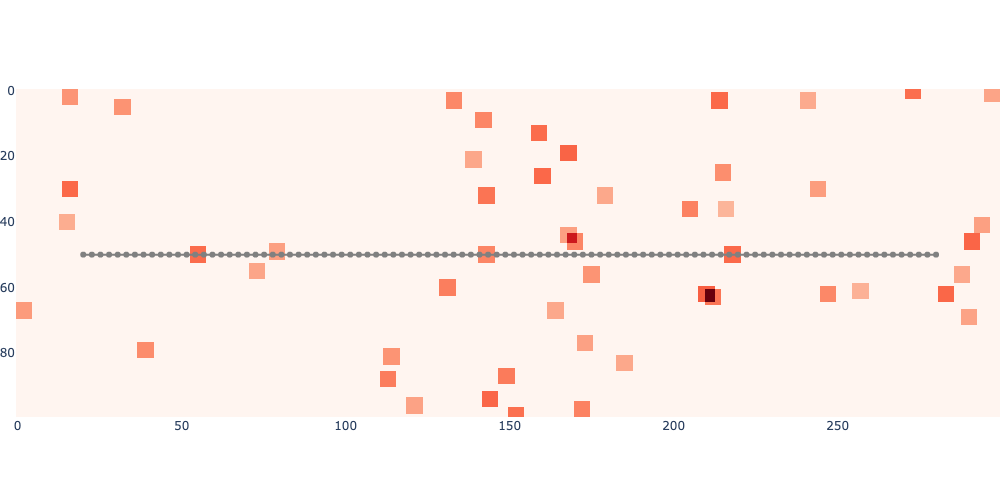

In [ ]:
#| caption: Initial path estimate plotted on the cost map.
#| label: fig:initial-path-on-map
initial_path = 10*gtsam.utilities.extractPoint2(initial)
fig = px.imshow(cost_map, color_continuous_scale='Reds')
fig.add_trace(go.Scatter(x=initial_path[:,0], y=initial_path[:,1], mode='lines+markers', line=dict(color='gray')))
fig.update_layout(coloraxis_showscale=False, showlegend=False, margin=dict(l=0, r=0, t=0, b=0), width=1000)

Plotting this path on the cost map in Figure [4](#fig:initial-path-on-map) shows that in this instance we are not lucky, however: the path definitely passes through some obstacles. We can immediately create all obstacle cost factors now, and evaluate the cost to confirm that this is not a zero-cost path. Since these factors are nonlinear, we store them in a `NonlinearFactorGraph`:

In [14]:
obstacle_factors = gtsam.NonlinearFactorGraph()
for k in range(1,M+1):
    custom_factor = gtsam.CustomFactor(None, [k], cost_func)
    obstacle_factors.add(custom_factor)
print(f"Graph has {obstacle_factors.size()} factors")

Graph has 100 factors


The cost profile along the path, shown in Figure [5](#fig:initial-costs-along-path) clearly shows the obstacles along the path. We can evaluate both the individual costs $\phi_k(X_k)^2$ and the sum-of-squares cost $\sum_k \phi_k(X_k)^2$ of a factor graph. The former gives us a cost profile along the way, and the latter represents an aggregate loss that we would like to minimize.

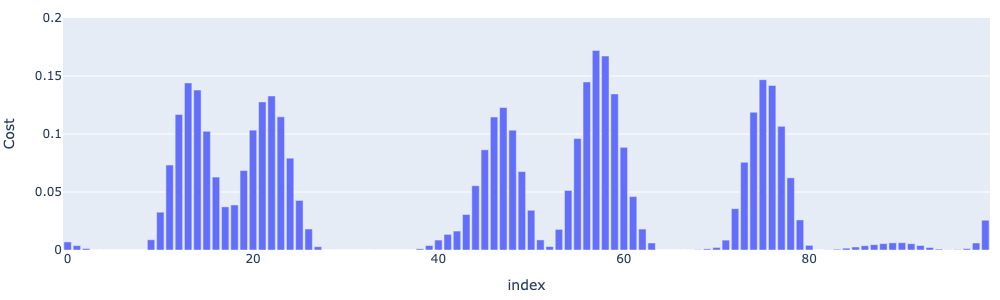

In [ ]:
#| caption: Costs for the initial trajectory estimate.
#| label: fig:initial-costs-along-path
costs = [obstacle_factors.at(i).unwhitenedError(initial) for i in range(M)]
fig = px.bar(costs, range_y=[0, 0.2])
fig.update_layout(yaxis_title='Cost', coloraxis_showscale=False, showlegend=False, height=300, width=1000, margin=dict(l=10, r=10, t=10, b=10))

A complete path/trajectory optimization problem needs more than just obstacle factors, however. We also need to add start and goal factors, as well as smoothness factors $\Psi(X_k,X_{k+1})$.  Smoothness factors are implemented in GTSAM using a `BetweenFactor`, 
and these help to ensure that the distance between successive points on the path is not too great.

Start and goal factors impose penalties when the starting point, $X_1$, is not near to the start position,
or the final point, $X_K$, is not near the goal position.
Both of these can be implemented as simple "priors" on the variables with keys $k=1$ and $k=100$. Note that a "prior factor" in GTSAM is just a quadratic cost, and in an estimation context that indeed corresponds to a Gaussian prior on a continuous point. In our current *planning* context we abuse that factor to simply have a quadratic cost at the path boundaries.

Both types of factors are added in the code below:

In [16]:
# We start by copying the obstacle factors:
graph = gtsam.NonlinearFactorGraph()
graph.push_back(obstacle_factors)

constrained2 = gtsam.noiseModel.Constrained.All(2) # We *insist* on the start and goal points!
graph.addPriorPoint2(1, start, constrained2)
graph.addPriorPoint2(M, goal, constrained2)

# The strength of the smoothness factors is controlled by a `precision` value: higher is stronger.
# Feel free to change the precision value below and see how the optimizer behaves:
smoothness_model = gtsam.noiseModel.Isotropic.Precision(2, 0.01)
for k in range(1, M):
    graph.add(gtsam.BetweenFactorPoint2(k, k+1, gtsam.Point2(0.0, 0.0), smoothness_model))

To optimize, we use a Levenberg Marquardt nonlinear optimizer. This optimizer, which we have encountered before in Section 6.4, linearizes the factors at every iteration and takes a cautious second-order minimization step. The "cautiousness" is governed by a parameter $\lambda$ that essentially selects between gradient descent ($\lambda$ high) and a second-order Gauss-Newton step ($\lambda$ low).  In our potentially very non-linear cost landscape it is good practice to start of the optimizer with a relatively high value for $\lambda$:

In [17]:
print(f"Initial cost: {graph.error(initial):.3f}")
params = gtsam.LevenbergMarquardtParams()
params.setlambdaInitial(100)
# params.setVerbosityLM("SUMMARY") # uncomment this line to see the LM progress
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)
result = optimizer.optimize()
print(f"Final cost: {graph.error(result):.3f}")

Initial cost: 0.236


Final cost: 0.064


```{index} pair: model-predictive control; MPC
```
The optimizer is very fast, on the order of milliseconds for this example, so it can be used in an online planner that continuously re-plans as the cost map is updated with new information. When used for flying a drone, we can execute on the initial part of the trajectory and then immediately re-plan. This scheme is version of **model-predictive control** (**MPC**), which is frequently used in actual autonomous vehicles and drones.

In our case, the optimizer finds a very nice path that navigates some tricky obstacle configurations, especially in the right half of the environment, as shown in Figure [6](#fig:final-trajectory-on-map).

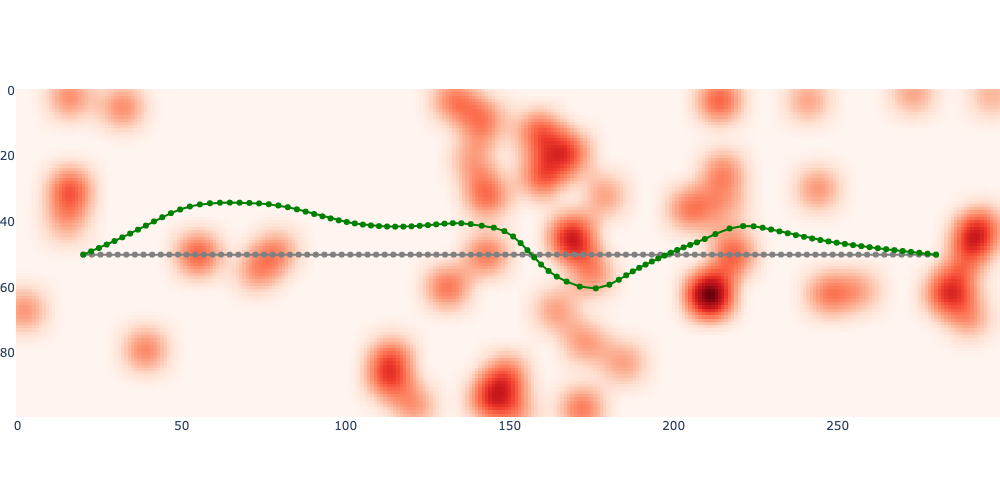

In [ ]:
#| caption: Initial and final path plotted on the blurred cost map.
#| label: fig:final-trajectory-on-map
result_path = 10*gtsam.utilities.extractPoint2(result)
fig = px.imshow(blurred, color_continuous_scale='Reds')
fig.add_trace(go.Scatter(x=initial_path[:,0], y=initial_path[:,1], mode='lines+markers', line=dict(color='gray')))
fig.add_trace(go.Scatter(x=result_path[:,0], y=result_path[:,1], mode='lines+markers', line=dict(color='green')))
fig.update_layout(coloraxis_showscale=False, showlegend=False, width=1000, margin=dict(l=0, r=0, t=0, b=0))

The cost profile along this final path is not entirely down to zero, as we have to navigate some tight obstacle configurations along the way. However, when plotted on the same scale it looks much better than for the initial path, as shown in Figure [7](#fig:final-cost-profile).

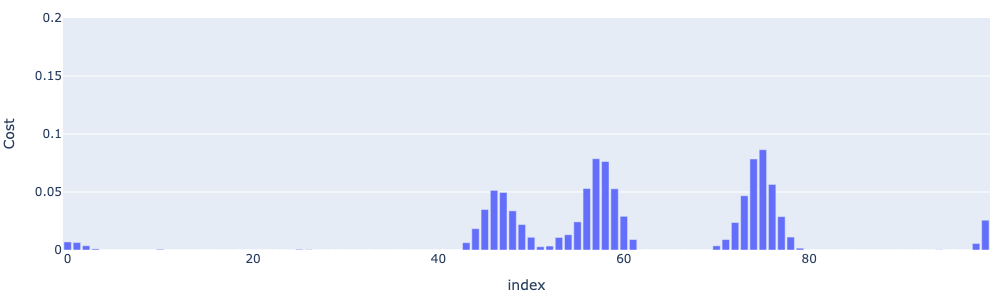

In [ ]:
#| caption: Costs for the optimized path.
#| label: fig:final-cost-profile
costs = [obstacle_factors.at(i).unwhitenedError(result) for i in range(M)]
fig = px.bar(costs, range_y=[0, 0.2])
fig.update_layout(yaxis_title='Cost', coloraxis_showscale=False, showlegend=False, width=1000, height=300, margin=dict(l=10, r=10, t=10, b=10))

### Exercise

Uncomment the line that calls `setVerbosityLM` in the optimization code to get a sense of how the optimization proceeds. Plot the result.

## Smoothing

> From path to trajectory.

We now convert our discretized optimal path to a discretized optimal *trajectory*. 
Here we will do so very simply by assigning a total execution time $T$ to the path. 
If we impose uniform $\Delta t$ between successive points in the path,
we can associate a time $t_k = (k-1) \Delta t$ to each point $X_k$ in the path.

We have to choose $T$ judiciously. 
We may want to go fast, but we need to make sure trajectory respects the drone's dynamic constraints:
a drone can't stop on a dime or go faster than certain limits. 
If we choose $T$ to be small, we are asking the drone to fly fast, and we might hit thrust limits. If we choose $T$ to be high, the drone will fly more slowly. For this example, we choose $T=20$ as a reasonable compromise,
as this should lead to an average velocity be a bit above 1 m/s.

Once we have a discretized translational trajectory that is well behaved, we can "upgrade" it to include
full position and attitude in two different ways: in advance, by solving a large optimization problem, or physically, in real-time, by using a tracking controller. The latter is what we will do below.

Even after assigning $T$, we still have only a discretized trajectory -- a  discrete set of points
with corresponding time stamps. A discretized trajectory is not great.
For example, it is not so easy to obtain accurate velocities and accelerations from a *discretized* trajectory. Below we use a class `SmoothTrajectory` which takes a discretized path and a given $T$, and fits a polynomial to
the discretized path. 
The smoothness of the resulting trajectory is determined by a parameter, $N$,
which defines the degree of the polynomial approximation.
Details of this process, however, are beyond the scope of this book.

The code to create this trajectory is shown below.
Note that above we computed a trajectory for a fixed altitude.
Here, we set the altitude to be a 1.5m. We choose $N=20$, which is a good trade off between computational cost and smoothness, but feel free to experiment with other values. Also, we set the flag `boundaries` to True, which enforces zero acceleration at the endpoints.

In [ ]:
# Add height of 1.5 meters to the path:
xy = gtsam.utilities.extractPoint2(result)
path = np.hstack([xy, np.full((len(xy),1), 1.5)])

T = 20.0
smooth = gtbook_drone.SmoothTrajectory(path, N=20, a=0, b=T, boundaries=True)

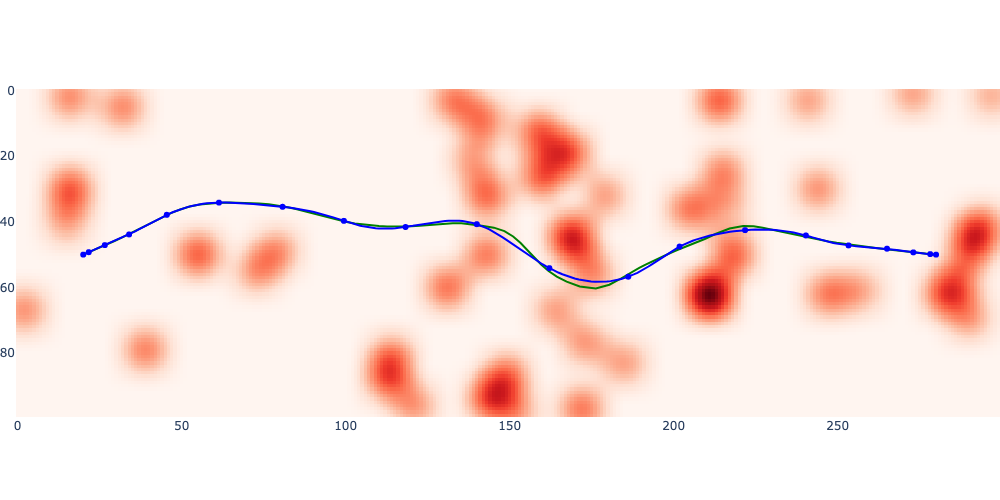

In [ ]:
#| caption: Discretized and smoothed trajectory.
#| label: fig:smoothed-path
timestamps = np.linspace(0.0 , T, 250)
desired_rn = smooth.evaluate(timestamps) # desired trajectory in navigation frame

fig = px.imshow(blurred, color_continuous_scale='Reds')
fig.add_trace(go.Scatter(x=result_path[:,0], y=result_path[:,1], mode='lines', line=dict(color='green')))
fig.add_trace(go.Scatter(x=10*desired_rn[:,0], y=10*desired_rn[:,1], mode='lines', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=10*smooth.points[:,0], y=10*smooth.points[:,1], mode='markers', line=dict(color='blue')))
fig.update_layout(coloraxis_showscale=False, showlegend=False, margin=dict(l=0, r=0, t=0, b=0), width=1000)

We can then evaluate and visualize the smoothed trajectory at *any* time t between 0 and T, as shown in Figure [8](#fig:smoothed-path).
Finally, it is instructive to inspect the velocity profiles as well, in Figure [9](#fig:smoothed-series-velocity). You can see that, for our chosen T=20, the drone flies at velocities between 1 and 1.6 m/s, which is what we expected for T=20.

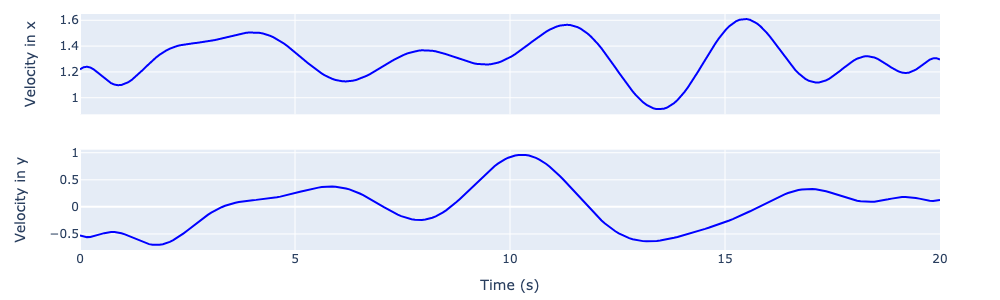

In [ ]:
#| caption: smoothed trajectory as time series.
#| label: fig:smoothed-series-velocity
desired_vn = smooth.velocities(timestamps) # desired velocity in navigation frame
desired_an = smooth.accelerations(timestamps) # desired acceleration in navigation frame
fig = pls.make_subplots(rows=2, cols=1, shared_xaxes=True)
fig.add_trace(go.Scatter(x=timestamps, y=desired_vn[:,0], mode='lines', line=dict(color='blue'), name='vx'), row=1, col=1)
fig.add_trace(go.Scatter(x=timestamps, y=desired_vn[:,1], mode='lines', line=dict(color='blue'), name='vy'), row=2, col=1)
fig.update_yaxes(title_text="Velocity in x", row=1, col=1)
fig.update_yaxes(title_text="Velocity in y", row=2, col=1)
fig.update_xaxes(title_text="Time (s)", row=2, col=1)
fig.update_layout(coloraxis_showscale=False, showlegend=False, width=1000, height=300, margin=dict(l=80, r=60, t=10, b=10))

## A Virtual Vectored Thrust

> What we want, in theory...

```{index} vectored thrust
```
We control the position of the drone using a 3DOF vectored thrust input: thrust magnitude, roll, and pitch. The idea outlined here is a simplified version of the geometric controller in a 2019 paper by {cite:t}`Gamagedara19acc_geometric_control`, but while the paper is fairly advanced, the idea is rather simple. Remember the translational equations of motion from Section 7.2,
\begin{equation}\begin{aligned}
\dot r^n &= v^n \\
m \dot v ^n &= R^n_b f + m g^n
\end{aligned}\end{equation}
where $m$ is the mass. Let us concentrate on the dynamics part: we *know* the acceleration $\dot v^n_d$ we want from our planned trajectory, and gravity is a given. Hence, to make the drone do what we want, we can only change the quantity $R^n_b f$. Let us call that the **vectored thrust** $T^n$, where the superscript $n$ denotes that the thrust is defined in the navigation frame. Then, to obtain the *desired* acceleration $\dot v^n_d$, the vectored thrust $T^n$ has to satisfy
\begin{equation}
T^n = m \dot v^n_d - m g^n.
\end{equation}
You can think of $T^n$, which is a 3D vector, as a thrust vector that pushes the drone toward where it needs to be. It can move the drone forwards or backwards by pitching appropriately, and left or right by rolling. But of course, at all times we need to make sure it cancels gravity as well, which explains the second term above. Even after gravity compensation, to gain or lose altitude, the thrust magnitude can be adjusted to make either happen. In control parlance, $T^n$ can be thought of as a *virtual control input*.

All of this is implemented in the `vectored_thrust` function below. It takes a `Drone` instance like the one we developed in Section 7.2, as well as a desired acceleration $a^n_d$. We redefined the `Drone` class in the `gtbook.drone` module so we can use it here, as well.

In [23]:
def vectored_thrust(drone:Drone, an_d:np.ndarray):
    """Calculate the vectored thrust at timestamp k."""
    return drone.mass * (an_d - drone.gn)

# now calculate all the desired thrust vectors:
drone = Drone(rn=desired_rn[0], vn=desired_vn[0], nRb=gtsam.Rot3(), wb=gtsam.Point3())
print(f"desired_thrust[0] = {vectored_thrust(drone, desired_an[0])}")
print(f"desired_thrust[-1] = {vectored_thrust(drone, desired_an[-1])}")

desired_thrust[0] = [ 0.25988069 -0.34011288  9.81      ]
desired_thrust[-1] = [-0.18333472  0.19575027  9.81      ]


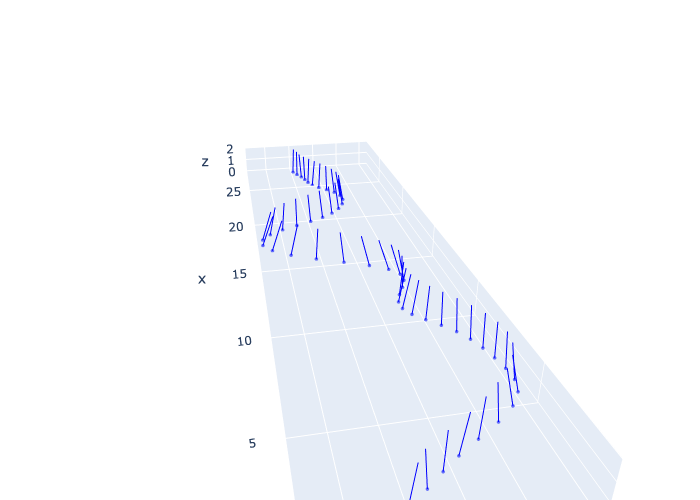

In [24]:
#| caption: Smoothed trajectory with vectored thrust vectors.
#| label: fig:vectored-thrust
X, Y, Z = desired_rn[::5, 0], desired_rn[::5, 1], np.zeros_like(desired_rn[::5, 0])

fig = px.scatter_3d(x=X, y=Y, z=Z)
fig.update_traces(marker=dict(size=2))

# Add thrust vectors as 3d arrows
vectors = np.array([vectored_thrust(drone, desired_an[k]) for k in range(0,250,5)])
Tx, Ty, Tz = 0.2*vectors[:, 0], 0.2*vectors[:, 1], 0.2*vectors[:, 2]
for i in range(len(X)):
    fig.add_trace(go.Scatter3d(x=[X[i], X[i] + Tx[i]], y=[Y[i], Y[i] + Ty[i]], z=[Z[i], Z[i] + Tz[i]],
                               mode='lines', line=dict(color='blue', width=2)))

# Set aspect ratio based on W and Height of the map
fig.update_layout(scene=dict(aspectratio=dict(x=1.2, y=H/W, z=2/W)))
fig.update_layout(coloraxis_showscale=False, showlegend=False, margin=dict(l=0, r=0, t=0, b=0))

# Apply the camera settings to the layout
fig.update_layout(scene_camera=dict(eye=dict(x=-1, y=0.2, z=0.5)))

Figure [10](#fig:vectored-thrust) shows the desired vectored thrust for the optimized trajectory for our example. If you execute this section's notebook you would be able to rotate the figure and ascertain that all thrust vectors, even if they are of different lengths, have exactly the same vertical projection magnitude. This is of course by design, to cancel out gravity in the absence of any requested vertical height changes.

## Combining Open Loop and Feedback Control

> What we want, in practice!

```{index} open-loop control
```
The virtual thrust vector is an example of an **open-loop control** strategy. 
Open-loop controllers provide a predefined input to the system at each moment of time,
without taking notice of how the system is actually performing.
Given the planned trajectory, we *calculate* what we think should happen at every moment,
and this is used as the control input. This could work *if* the drone perfectly tracks the planned trajectory;
however, inevitably small errors will occur, maybe through wind, or model inaccuracies, or small variations in motor thrust. In addition, motors might hit their thrust limits and not be able to deliver the desired thrust completely. More importantly the pitch/roll controller (see below) that is supposed to deliver the thrust vector direction will have a small but consequential lag. All of these issues mean that errors *will* occur and the system will have to deal with them. 

```{index} feedback control, closed-loop control
```
To make this work, we need to incorporate **feedback control** terms that correct for tracking errors.
Feedback, or *closed-loop control*, allows the input at each moment of time to be a function of the drone's
state.
A typical approach is to define the control input as a function of the error
between desired and observed behavior.
In our case, we will use the position and velocity errors.
We define
the *desired* position $X_d$ and *desired* velocity $\dot X_d$ at any given time,
which leads to the following controller:
\begin{equation}
T^n = m \dot v^n_d - m g^n - K_x (X - X_d) - K_v (\dot X - \dot X_d)
\end{equation}
This now requires tuning two additional parameters, $K_x$ and $K_v$, for the *proportional* and *derivative* control terms respectively (such a controller is called, appropriately, PD control). 

It *is* important to note that $X_d$ and $\dot{X}_d$ are exactly the optimal trajectory that we computed above. The subscript $d$ denotes "desired" and strictly speaking these are functions of time $t$, as are the current position $X$ and velocity $\dot X$. However, we chose to not clutter up the notation too much by explicitly omitting the time dependence. 

The proposed controller is relatively easy to implement in code:

In [25]:
def thrust_controller(drone, rn_d, vn_d, an_d, Kx=1.0, Kv=1.0):
    """Calculate the vectored thrust, adjusted for tracking errors, given desired rn/vn."""
    Tn = vectored_thrust(drone, an_d)
    Tn -= Kx * (drone.rn - rn_d)
    Tn -= Kv * (drone.vn - vn_d)
    return Tn

# Usage example:
Tn = thrust_controller(drone, desired_rn[1], desired_vn[1], desired_an[1])
print(f"Tn = {Tn}")

Tn = [ 0.24371061 -0.25264278  9.81      ]


```{index} controller gain
```
We can set up a small simulation to see how this controller behaves in practice, and in particular how the controller behaves for different values of $K_x$ and $K_v$. Constants like $K_x$ and $K_v$ are called **controller gains**, and choosing the gains optimally is a standard problem in control theory.

In Figure [11](#fig:executed_vs_desired) we use the same simulation strategy as in Section 7.2, and in particular use the `Drone` class that was defined there. In the simulation below we do not worry about the rotation yet. Plotting the executed trajectory on the map, below the code, shows we are almost tracking perfectly now. In Figure [12](#fig:outer-controller-3d) we show the 3D view, which shows the same.

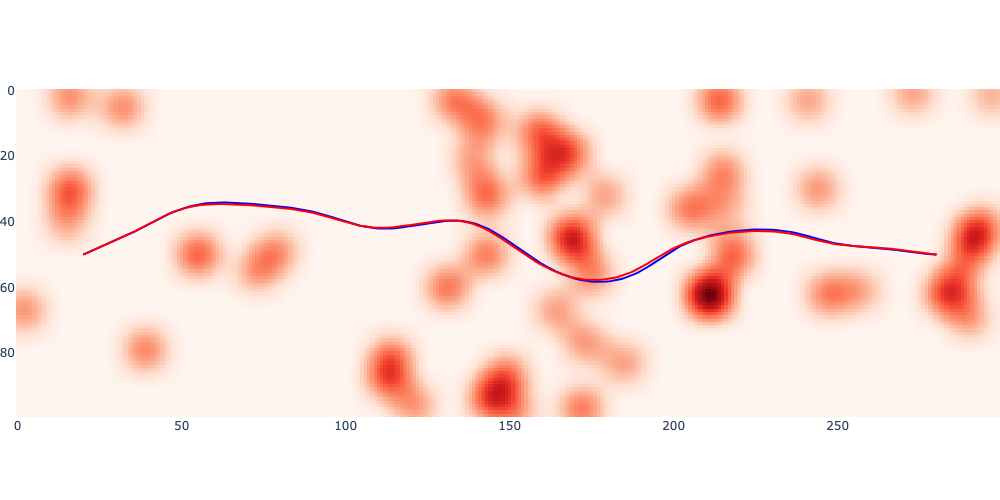

In [ ]:
#| caption: The executed trajectory, in red, as compared with the desired trajectory, in blue.
#| label: fig:executed_vs_desired
K = len(desired_rn)
delta_t = T / K # time between samples

# Initialize the drone:
drone = Drone(rn=desired_rn[0].copy(), vn=desired_vn[0].copy(), nRb=gtsam.Rot3(), wb=gtsam.Point3(0,0,0))

# reserve space for the executed trajectory:
executed = np.zeros((K+1, 3))

# integrate forward
executed[0] = drone.rn
for k in range(K):
    desired_Tn = thrust_controller(drone, desired_rn[k], desired_vn[k], desired_an[k])
    drone.integrate_thrust_vector(desired_Tn, delta_t)
    drone.integrate_kinematics(delta_t)
    executed[k+1] = drone.rn

fig = px.imshow(blurred, color_continuous_scale='Reds')
fig.add_trace(go.Scatter(x=10*desired_rn[:,0], y=10*desired_rn[:,1], mode='lines', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=10*executed[:,0], y=10*executed[:,1], mode='lines', line=dict(color='red')))
fig.update_layout(coloraxis_showscale=False, showlegend=False, width=1000, margin=dict(l=0, r=0, t=0, b=0))

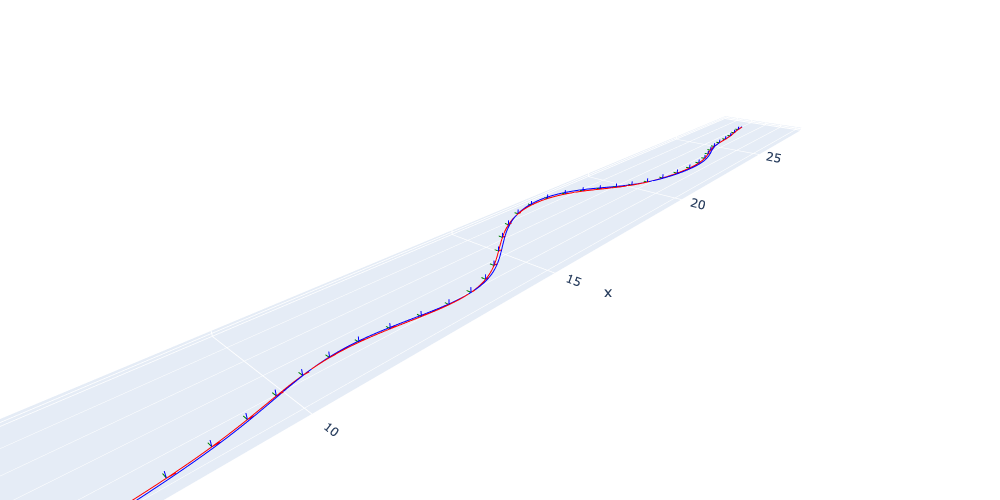

In [28]:
#| caption: 3D trajectory using virtual thrust control.
#| label: fig:outer-controller-3d
nRb = np.tile(np.eye(3),(K,1,1)) # level attitude
fig = gtbook_drone.show_executed(desired_rn, executed, nRb, K, 1)
fig.update_layout(scene_camera=dict(eye=dict(x=-4, y=-3.5, z=2.5)), width=1000).show()

### Exercises:
- Try setting the proportional and derivative constants $K_x$ and $K_v$ to 0, in isolation or both. Describe to yourself what happens.
- Try setting one or the other to a very high value (1000). What is happening now?

## Vectoring using Fast Rotational Dynamics

While we cannot *instantaneously* produce the desired vectored thrust $T^n$ at any given time, the dynamics of a quadrotor are fast enough that we can get rather close. Remember that the inertia matrix, which resists rotational acceleration, is typically small around the roll and pitch axes. Let us recall the (approximate) rotational equations of motion, in the body frame $B$:
\begin{equation}\begin{aligned}
\dot{R}^n_b	&= R^n_b\hat{\omega}^b \\
I \dot{\omega}^b &\approx \tau^b
\end{aligned}\end{equation}
For typical drone configurations the inertia matrix $I$ can be well approximated as $\text{diag}(I_{xx},I_{yy},I_zz)$, with the roll-pitch components $I_{xx}, I_{yy} << I_{zz}$, the yaw component. Since $I_{xx}$ and $I_{yy}$ are small, and we have four powerful motors that can provide differential thrust very quickly, those dynamics are quite fast. Hence, if the attitude $R^n_b$ does not yet align the total thrust $f$ with the desired thrust vector $T^n$, we can quickly make it so by rotating.

```{index} pair: first person view; FPV
```
To understand how to make the drone tilt, think of a video game where you are given a two axis controller and the screen displays the *current* orientation of the drone's z-axis and the *desired* thrust vector $T^n$. Your job is to align the two by rolling (rotate around the body x-axis) and pitching (rotating around the body y-axis). Looking at the drone from the outside, in the navigation frame, this will actually be rather hard: typically the controls are fixed to the *body* frame, and at every step you need to perform a mental rotation to find the right action. That is why racing drone pilots much prefer to use a *first person view* or FPV display and controller.

```{index} proportional control
```
The mathematical equivalent of FPV for a control *algorithm* is to rotate everything into the body frame. Taking the desired thrust vector $T^n_d$ and multiplying it with the transpose of the attitude $R^n_b$ (which is the inverse rotation, recall Sections 6.1 and 7.1) yields the desired thrust vector $T^b_d$ in the body frame:
\begin{equation}
T^b_d = (R^n_b)^T T^n_d = \begin{bmatrix}T_{Fd}\\T_{Ld}\\T_{Ud}\end{bmatrix}.
\end{equation}
Remember we use the Forward-Left-Up convention for the body frame, so let us examine each component $T_{Fd}$,  $T_{Ld}$, and $T_{Ud}$ of the thrust vector $T^b_d$ in turn.

- When $T_{Fd}$ is *positive*, the desired thrust vector is ahead of the drone, and we should *pitch* forward. Looking from the tip of the Left/$y$-axis, this corresponds to a counter-clockwise, i.e., positive angular velocity $\omega^b_y>0$ around the Left/$y$-axis Likewise, if $T_{Fd}$ is *negative*, we should rotate clockwise around the $y$-axis, i.e., $\omega^b_y>0$. This inspires a control law for the torque around Y as follows:
\begin{equation}
    \tau^b_y = K_F T_{Fd}.
\end{equation}
- When $T_{Ld}$ is positive, the desired thrust vector is to the left, and we should *roll*. Looking from the tip of the Forward/$x$-axis, this corresponds to a clockwise, i.e., *negative* angular velocity $\omega^b_x$. This inspires a control law for the torque around X as follows:
\begin{equation}
    \tau^b_x = - K_L T_{Ld}.
\end{equation}
- The component $T_{Ud}$ along the body Up/$z$-axis is a good approximation of the total thrust we need, and in fact is exactly correct if the thrust vector is already aligned correctly. So, we set
\begin{equation}
    f = T_{Ud}.
\end{equation}
The three control laws above constitute a simple *proportional* control law for the drone, with $-T_{Fd}$ and $T_{Ld}$ acting as errors to be driven to zero. The gains $K_F$ and $K_L$ govern how aggressive the controller is:
the higher the gains, the faster the controller will try to remove those errors, but this could also lead to oscillations and even instabilities.
We could obtain a more stable controller by once again adding a derivative term, but we won't attempt that here.

In Figure [12](#fig:attitude-controller) we show a code example with $K_F = K_L = K = 0.1$, which illustrates the behavior: we want to increase the thrust $T_F$ in the $x$ direction to $0.26$, so we will positively *pitch* around the y-axis: counter-clockwise, pointing the $z$-axis forward. Likewise, we want a thrust towards the right ($T_L = -0.34$), so we need to roll counter-clockwise, as well, around the Forward/$x$-axis.

In [ ]:
#| caption: Attitude controller applied to the desired thrust vectors.
#| label: fig:attitude-controller
def attitude_controller(nT: np.ndarray, nRb: gtsam.Rot3, K: float = 0.1):
    """Calculate the vectored thrust for the desired thrust vector, given in nav frame."""
    # Rotate the desired thrust vector to body frame:
    T_F, T_L, T_U = nRb.unrotate(nT) # equivalent to nRb.inverse().rotate(nT)

    # Calculate the desired roll and pitch torques:
    tau_x = - K * T_L
    tau_y = K * T_F

    # Return alongside total thrust to be commanded:
    return tau_x, tau_y, T_U

nRb = gtsam.Rot3() # Assume the robot is initially level
print(f"vectors[0] = {np.round(vectors[0],2)}")
print(f"control[0] = {np.round(attitude_controller(vectors[0], nRb),4)}")

vectors[0] = [ 0.26 -0.34  9.81]
control[0] = [0.034 0.026 9.81 ]


### Calculating Motor Thrust Vectors

Creating the requested torque and thrust by the control law is done by adjusting the individual motor thrusts $f_i$. Recalling the force-torque equation in Section 7.2, if we ensure $f_{1} + f_{3} = f_{2} + f_{4}$ (which makes the yaw moment zero) we obtain:
\begin{equation}
\tau^b = l \begin{bmatrix}
f_{1}-f_{2}-f_{3}+f_{4}\\
f_{1}+f_{2}-f_{3}-f_{4}\\
0
\end{bmatrix}
\end{equation}
The thrust vector magnitude $F^b_z = f$ can be adjusted quickly as well:
\begin{equation}
f = f_1 + f_2 + f_3 + f_4.
\end{equation}
and hence we now have four equations in four unknowns. Solving for the forces yields
\begin{equation}\begin{aligned}
f_1 &= 0.25 \left( f + \tau_x/l + \tau_y/l \right) \\
f_2 &= 0.25 \left( f - \tau_x/l + \tau_y/l \right) \\
f_3 &= 0.25 \left( f + \tau_x/l - \tau_y/l \right) \\
f_4 &= 0.25 \left( f - \tau_x/l - \tau_y/l \right)
\end{aligned}\end{equation}
where $l$ is the arm length, and $\tau_x$ and $\tau_y$ are the roll and pitch moment, respectively.

The piece of code below implements this; however, this simplified code does not make any guarantees on not hitting torque limits. Hence, in practice more sophisticated approaches are used return a solution subject to actual control limits, while still trying to deliver some desired torques and/or thrust.

In [30]:
def control_to_motor_speeds(tau_x: float, tau_y: float, f: float, L: float = np.sqrt(0.002)):
    """Convert the desired torques and thrust to motor speeds."""
    # Calculate the motor speeds:
    f_1 = 0.25 * (f + tau_x/L + tau_y/L)
    f_2 = 0.25 * (f - tau_x/L + tau_y/L)
    f_3 = 0.25 * (f + tau_x/L - tau_y/L)
    f_4 = 0.25 * (f - tau_x/L - tau_y/L)

    # Return as a tuple
    return f_1, f_2, f_3, f_4

print(f"motor_speeds[-1] = {control_to_motor_speeds(*attitude_controller(vectors[-1], nRb))}")

motor_speeds[-1] = (2.670523603807631, 2.5035980337877324, 2.401401966212205, 2.234476396192306)


## Code Example

```{index} cascaded control
```
To simulate both controllers working together, we now also need to account for attitude.
The code in Figure [13](#full-control-loop) shows how to implement the entire control scheme.
Note that in the code we now have an outer and an inner loop.
The outer loop is for the "slow" translational dynamics, whereas the inner loop simulates the "fast" attitude dynamics.
Such a **cascaded controller** is a typical design choice for drone applications.

Figures [14](#cascaded-control-2d) and [15](#cascaded-control-3d) show the resulting closed-loop trajectory. From the 3D plot we see that the controller tracks the desired trajectory quite well.

### Exercise

Try playing with the gain $K$ of the attitude controller. What do you observe. Any theories?

In [ ]:
#| caption: Full control loop with thrust and attitude controller.
#| label: fig:full-control-loop
dt = delta_t/10

# Reserve space for the executed trajectory, including attitude:
executed = np.zeros((K+1, 3))
nRb = np.zeros((K + 1, 3, 3), float)

# We again initialize at the desired position and velocity for k=0,
# and (as before) have the drone face east (x-axis in navigation frame) initially:
drone = Drone(rn=desired_rn[0].copy(), vn=desired_vn[0].copy(), nRb=gtsam.Rot3(), wb=gtsam.Point3(0,0,0))

nRb = np.zeros((K + 1, 3, 3), float) # Now also store attitude

# integrate forward
executed[0] = drone.rn
nRb[0] = drone.nRb.matrix()
for k in range(K):
    desired_Tn = thrust_controller(drone, desired_rn[k], desired_vn[k], desired_an[k])

    # Inner loop: a fast roll/pitch controller:
    for j in range(10):
        # Calculate roll/pitch/thrust controls:
        tau_x, tau_y, T_U = attitude_controller(desired_Tn, drone.nRb, K=0.5)

        # clip thrust to be between 0 and 20 Newtons:
        T_U = np.clip(T_U, 0, 20)

        # Integrate both dynamics and kinematics in one step:
        drone.integrate(T_U, gtsam.Point3(tau_x, tau_y, 0), dt)

    executed[k+1] = drone.rn
    nRb[k] = drone.nRb.matrix()

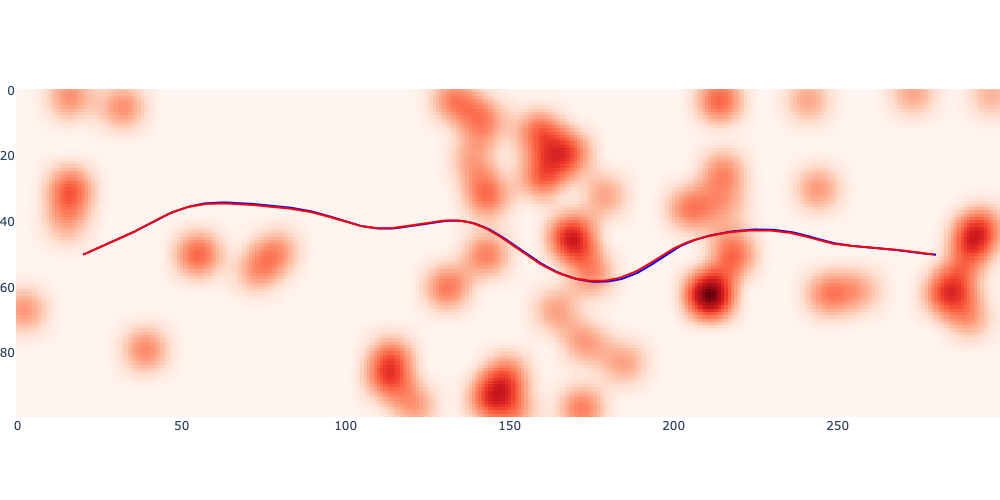

In [32]:
#| caption: 2D trajectory using cascaded controller, on cost map.
#| label: fig:cascaded-control-2d
fig = px.imshow(blurred, color_continuous_scale='Reds')
fig.add_trace(go.Scatter(x=10*desired_rn[:K,0], y=10*desired_rn[:K,1], mode='lines', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=10*executed[:K,0], y=10*executed[:K,1], mode='lines', line=dict(color='red')))
fig.update_layout(coloraxis_showscale=False, showlegend=False, width=1000, margin=dict(l=0, r=0, t=0, b=0))

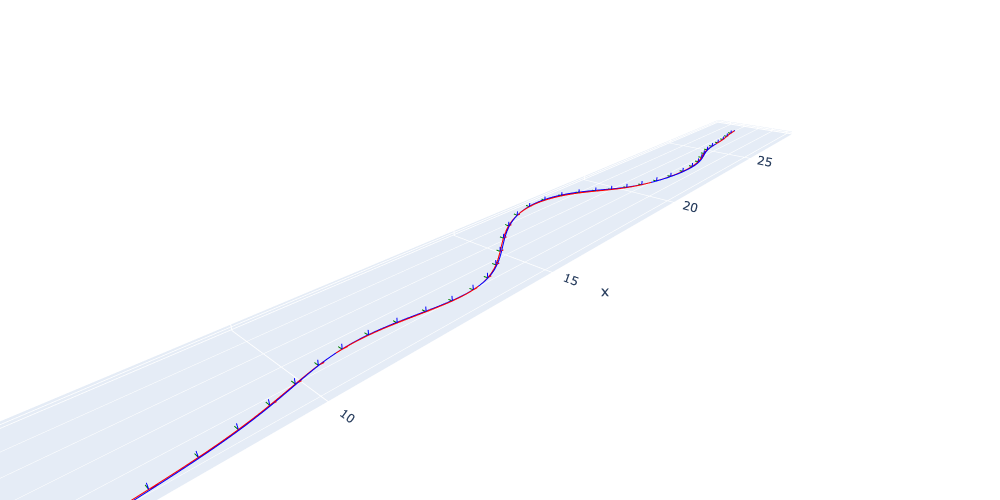

In [33]:
#| caption: 3D trajectory with cascaded controller.
#| label: fig:cascaded-control-3d
fig = gtbook_drone.show_executed(desired_rn, executed, nRb, K, 1)
fig.update_layout(scene_camera=dict(eye=dict(x=-4, y=-3.5, z=2.5)), width=1000).show()

## Planning and Controlling Yaw

Controlling yaw is a crucial aspect in the design of FPV or camera drones, as it enables a drone to point in a specific direction. Since often the drone is equipped with a forward-looking camera, this is obviously useful. 

A simple yaw controller can be implemented to address this, but we will not discuss it in detail here. We would need to also plan the viewing direction of the drone, which involves setting up another objective etc. For example, we could try to ensures that the drone remains pointed at a particular object, e.g., for tasks like aerial photography or inspection.

Yaw control presents more challenges compared to roll/pitch control. This is because yaw involves imparting a moment around the z-axis, which cannot be done using differential force control. Rather, a moment around the z-axis is created by the moments of the rotors themselves: two spin clockwise, and two others counter-clockwise. By making one or the other pair spin faster, a net moment is imparted. However, the moments so produced are much smaller.